*1.0    Chequear requisitos tecnicos :*

In [1]:
# Versión de Python
!python3 --version

# Versión de PySpark
import pyspark
print(pyspark.__version__)



Python 3.6.15
2.3.0


In [8]:
from pyspark.sql.functions import when,sum,md5,hour
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import sys
print(sys.executable) #

/usr/bin/python3


In [10]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("ReadFile").getOrCreate()

###  1.1  Calcular el monto total que facturara el proveedor del servicio por envios de sms

In [15]:
# Levantar ambos datasets csv
df_events = spark.read.csv(
    "/home/jovyan/work/test_grandata_data_engineer/events.csv.gz",
    header=True,
    inferSchema=True,
)
df_freesms = spark.read.csv(
    "/home/jovyan/work/test_grandata_data_engineer/free_sms_destinations.csv.gz",
    header=True,
    inferSchema=True,
)

# Filtrar los registros que no están en free_sms_destinations
df_payed = df_events.join(df_freesms, df_events.id_destination == df_freesms.id, "leftanti")
df_payed = df_payed.filter((df_payed.id_source.isNotNull()) & (df_payed.id_destination.isNotNull()))
df_payed = df_payed.filter(df_payed.sms != 0)

# Calculo  costo x región
df_payed = df_payed.withColumn(
    "toPay",
    when((df_payed.region >= 1) & (df_payed.region <= 5), 1.5)
    .when((df_payed.region >= 6) & (df_payed.region <= 9), 2.0)
    .otherwise(None),
)

# Suma del total a facturar
sum_total = df_payed.agg(sum("toPay")).collect()[0][0]
print("El monto total que facturara el proveedor del servicio por envios de sms es $", sum_total)


El monto total que facturara el proveedor del servicio por envios de sms es $ 140757.0


### 1.2 Generar un dataset que contenga los ID de los 100 usuarios con mayor facturacion por envio de sms y el monto total a facturar a cada uno. Ademas del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresion gzip.


In [12]:

# Top 100 clientes con mayor facturación
df_maxbilling = (
    df_payed.groupBy("id_source")
    .agg(sum("toPay").alias("total_payment"))
    .orderBy("total_payment", ascending=False)
    .limit(100)
)

# Hasheo de ids
df_with_hash = df_maxbilling.withColumn("hashed_id", md5(df_maxbilling.id_source))
df_with_hash.show()

# Almacenar el dataset como Parquet comprimido
output_path = "/home/jovyan/work/output/max_billing"
df_with_hash.write.format("parquet").option("compression", "gzip").mode("overwrite").save(output_path)

print("El dataset en formato parquet con compresion gzip se ha guardo correctamente en la ruta : </home/jovyan/work/output/max_billing>")




+---------+-------------+--------------------+
|id_source|total_payment|           hashed_id|
+---------+-------------+--------------------+
|      4D3|      18201.5|911914c7729eedbdf...|
|      76D|      13128.0|bd180b7811395cbce...|
|      07E|       3620.0|14a0660ae2f5d1868...|
|      541|       1361.0|16c222aa19898e505...|
|      B86|        950.5|bc97b32ee2abb9c18...|
|      3AE|        672.0|6a57072949dbc409c...|
|      1BD|        657.5|f5a45e33602ea62f9...|
|      3E0|        628.5|e9d076deb3451cc49...|
|      E6F|        318.0|159e1f3d6ff0e7c3c...|
|      D0B|        291.5|e87c495061191f4df...|
|      BD4|        274.5|aa35b36e4d1395542...|
|      8F1|        269.5|496ce5f942d15eefb...|
|      556|        212.5|11b921ef080f77360...|
|      E21|        206.0|6f916a6c36cd500c3...|
|      24F|        168.5|9f4c6198e4de6db74...|
|      498|        159.5|05f971b5ec196b8c6...|
|      ED9|        134.5|7d7d2b7b7d0b01a87...|
|      2B1|        123.5|2cf07ff95f0cec031...|
|      79F|  

### 1.3 Graficar un histograma de cantidad de llamadas que se realizan por hora del dia.

El histograma ha sido guardado en la ruta: </home/jovyan/work/output/histograma_llamadas.png >


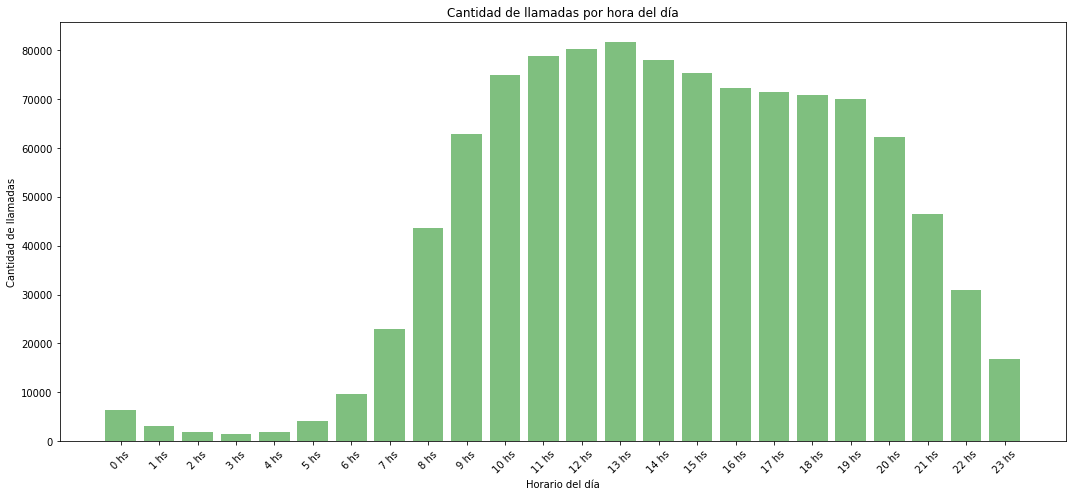

In [16]:
# Calcular el histograma de llamadas por hora
df_events_histo = df_events.filter(
    (df_events.id_source.isNotNull()) & (df_events.id_destination.isNotNull())
)

calls_per_hour = (
    df_events_histo.groupBy("hour")
    .agg(sum("calls").alias("cantllamadasxhoraxdia"))
    .orderBy("hour")
)

# Recoger los datos para graficar
hours = calls_per_hour.select("hour").rdd.flatMap(lambda x: x).collect()
counts = calls_per_hour.select("cantllamadasxhoraxdia").rdd.flatMap(lambda x: x).collect()



def format_hs(hour):
    hour_int = int(hour)
    return f"{hour_int} hs"

# Validar que haya datos antes de graficar
if hours and counts:
    plt.figure(figsize=(15, 7))
    plt.bar(hours, counts, align="center", alpha=0.5,color='green')
    plt.xlabel("Horario del día")
    plt.ylabel("Cantidad de llamadas")
    plt.title("Cantidad de llamadas por hora del día")
    
    # Formatear el eje X con las horas convertidas a AM/PM
    formatted_hours = [format_hs(hour) for hour in hours]
    plt.xticks(hours, formatted_hours, rotation=45)
    
    plt.tight_layout()
    plt.gcf().set_facecolor('white')
    
    # Guardar la imagen del histograma como un archivo
    output_image_path = "/home/jovyan/work/output/histograma_llamadas.png"
    plt.savefig(output_image_path, bbox_inches='tight', transparent=False) 
    print("El histograma ha sido guardado en la ruta: </home/jovyan/work/output/histograma_llamadas.png >" )
    
    plt.show()

else:

    print("No se encuentran los datos para graficar.")


In [ ]:
#Termina la Sesion
spark.stop()